# Naive Bayes – rozwiązania zadań



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)


## Zadanie 1 – Email Spam

Dane o 12 emailach (cechy kategoryczne) i etykieta `Spam`.

W części (a) pokazuję obliczenia „ręczne” (wprost z definicji Naive Bayes), a w (b) implementuję to w Pythonie **bez sklearn**. W (c) porównuję z `CategoricalNB` z sklearn.


In [2]:
data_spam = {
    'Słowo_1': ['darmowy', 'darmowy', 'spotkanie', 'raport', 'oferta', 'darmowy',
                'spotkanie', 'oferta', 'raport', 'darmowy', 'spotkanie', 'oferta'],
    'Słowo_2': ['wygrana', 'wygrana', 'jutro', 'kwartalny', 'specjalna', 'rabat',
                'dziś', 'limitowana', 'miesięczny', 'rabat', 'pilne', 'wyjątkowa'],
    'Wykrzyknik': ['TAK', 'TAK', 'NIE', 'NIE', 'TAK', 'TAK',
                   'NIE', 'TAK', 'NIE', 'TAK', 'NIE', 'TAK'],
    'Spam': ['TAK', 'TAK', 'NIE', 'NIE', 'NIE', 'TAK',
             'NIE', 'NIE', 'NIE', 'TAK', 'NIE', 'NIE']
}

df_spam = pd.DataFrame(data_spam)
df_spam

,Słowo_1,Słowo_2,Wykrzyknik,Spam
0,darmowy,wygrana,TAK,TAK
1,darmowy,wygrana,TAK,TAK
2,spotkanie,jutro,NIE,NIE
3,raport,kwartalny,NIE,NIE
4,oferta,specjalna,TAK,NIE
5,darmowy,rabat,TAK,TAK
6,spotkanie,dziś,NIE,NIE
7,oferta,limitowana,TAK,NIE
8,raport,miesięczny,NIE,NIE
9,darmowy,rabat,TAK,TAK


### 1a) Ręczne obliczenia (na danych)

1. **Prawdopodobieństwa a priori**:  
   \(P(Spam=TAK)\) i \(P(Spam=NIE)\)

2. **Prawdopodobieństwa warunkowe** dla każdej cechy, np.  
   \(P(Słowo\_1=darmowy\mid Spam=TAK)\), \(P(Wykrzyknik=TAK\mid Spam=NIE)\), itd.

3. **Predykcja** dla nowego emaila:
- `Słowo_1='darmowy'`
- `Słowo_2='wygrana'`
- `Wykrzyknik='TAK'`

Naive Bayes (dla cech niezależnych warunkowo):
\[
P(c\mid x) \propto P(c) \prod_i P(x_i\mid c)
\]

> Uwaga: bez wygładzania (Laplace’a) łatwo dostajemy zera, jeśli jakaś wartość cechy nie wystąpiła w danej klasie.


In [3]:
# 1) Prawdopodobieństwa a priori
priors = df_spam['Spam'].value_counts(normalize=True)
priors

,proportion
Spam,
NIE,0.666667
TAK,0.333333


In [4]:
# 2) Prawdopodobieństwa warunkowe (bez wygładzania)
features = ['Słowo_1', 'Słowo_2', 'Wykrzyknik']
classes = sorted(df_spam['Spam'].unique())

cond_no_smooth = {}
for col in features:
    # rozkład P(x|c) jako tabela częstości normalizowana w kolumnach (po klasach)
    cond_no_smooth[col] = pd.crosstab(df_spam[col], df_spam['Spam'], normalize='columns')

cond_no_smooth

{'Słowo_1': Spam         NIE  TAK
 Słowo_1              
 darmowy    0.000  1.0
 oferta     0.375  0.0
 raport     0.250  0.0
 spotkanie  0.375  0.0,
 'Słowo_2': Spam          NIE  TAK
 Słowo_2               
 dziś        0.125  0.0
 jutro       0.125  0.0
 kwartalny   0.125  0.0
 limitowana  0.125  0.0
 miesięczny  0.125  0.0
 pilne       0.125  0.0
 rabat       0.000  0.5
 specjalna   0.125  0.0
 wygrana     0.000  0.5
 wyjątkowa   0.125  0.0,
 'Wykrzyknik': Spam          NIE  TAK
 Wykrzyknik            
 NIE         0.625  0.0
 TAK         0.375  1.0}

In [5]:
# Wyświetlmy czytelnie te rozkłady
for col in features:
    print(f"\nP({col} | Spam)")
    display(cond_no_smooth[col])


P(Słowo_1 | Spam)


Spam,NIE,TAK
Słowo_1,,
darmowy,0.000,1.0
oferta,0.375,0.0
raport,0.250,0.0
spotkanie,0.375,0.0



P(Słowo_2 | Spam)


Spam,NIE,TAK
Słowo_2,,
dziś,0.125,0.0
jutro,0.125,0.0
kwartalny,0.125,0.0
limitowana,0.125,0.0
miesięczny,0.125,0.0
pilne,0.125,0.0
rabat,0.000,0.5
specjalna,0.125,0.0
wygrana,0.000,0.5



P(Wykrzyknik | Spam)


Spam,NIE,TAK
Wykrzyknik,,
NIE,0.625,0.0
TAK,0.375,1.0


In [6]:
new_email = {'Słowo_1': 'darmowy', 'Słowo_2': 'wygrana', 'Wykrzyknik': 'TAK'}
new_email

{'Słowo_1': 'darmowy', 'Słowo_2': 'wygrana', 'Wykrzyknik': 'TAK'}

In [7]:
# 3) Posterior bez wygładzania (może wyjść 0 dla jednej z klas)

scores = {}
for c in classes:
    p = priors[c]
    for col, val in new_email.items():
        p *= cond_no_smooth[col].loc[val, c] if val in cond_no_smooth[col].index else 0.0
    scores[c] = p

scores, {c: scores[c]/sum(scores.values()) if sum(scores.values())>0 else np.nan for c in classes}

({'NIE': np.float64(0.0), 'TAK': np.float64(0.16666666666666666)},
 {'NIE': np.float64(0.0), 'TAK': np.float64(1.0)})

Widzimy, że bez wygładzania klasa `NIE` ma wynik 0, bo w danych **nigdy** nie wystąpiło `Słowo_2='wygrana'` w klasie `Spam=NIE`.

Dlatego często stosuje się **wygładzanie Laplace’a** (add-1):
\[
P(x=v\mid c)=\frac{\text{liczba}(x=v, c)+\alpha}{\text{liczba}(c)+\alpha\cdot K}
\]
 gdzie:
- \(K\) – liczba możliwych wartości danej cechy,
- \(\alpha=1\) – klasyczne wygładzanie Laplace’a.


In [8]:
def fit_nb_categorical(df: pd.DataFrame, target: str, alpha: float = 0.0):
    """Prosty Naive Bayes dla cech kategorycznych.

    Zwraca:
    - classes: lista klas
    - priors: dict P(c)
    - cond: dict {feature: {class: {value: P(value|class)}}}
    - values_per_feature: dict {feature: [unikalne wartości]}
    """
    X = df.drop(columns=[target])
    y = df[target]
    classes = sorted(y.unique())
    priors = (y.value_counts(normalize=True)).to_dict()

    cond = {}
    values_per_feature = {}
    for col in X.columns:
        values = sorted(X[col].unique())
        values_per_feature[col] = values
        cond[col] = {}
        for c in classes:
            subset = X[y == c][col]
            counts = subset.value_counts().to_dict()
            denom = len(subset) + alpha * len(values)
            cond[col][c] = {v: (counts.get(v, 0) + alpha) / denom for v in values}

    return classes, priors, cond, values_per_feature


def predict_proba(sample: dict, classes, priors: dict, cond: dict):
    """Zwraca (nieznormalizowane) wyniki i znormalizowane posterior P(c|x)."""
    scores = {}
    for c in classes:
        p = priors[c]
        for col, val in sample.items():
            p *= cond[col][c].get(val, 0.0)
        scores[c] = p

    total = sum(scores.values())
    posterior = {c: (scores[c] / total if total > 0 else np.nan) for c in classes}
    return scores, posterior


In [9]:
# Obliczenia z wygładzaniem Laplace'a (alpha=1)
classes_nb, priors_nb, cond_nb, values_nb = fit_nb_categorical(df_spam, target='Spam', alpha=1.0)

scores_lap, post_lap = predict_proba(new_email, classes_nb, priors_nb, cond_nb)

scores_lap, post_lap

({'NIE': 0.0012345679012345679, 'TAK': 0.03720238095238095},
 {'NIE': 0.03211930025810152, 'TAK': 0.9678806997418985})

**Wniosek:** po wygładzaniu Laplace’a dostajemy sensowne (niezerowe) prawdopodobieństwa dla obu klas, ale nadal zdecydowanie wygrywa `Spam=TAK`.


### 1c) Sklearn – `CategoricalNB`

`CategoricalNB` działa na liczbach całkowitych, więc koduję wartości cech (osobny `LabelEncoder` dla każdej kolumny). Następnie porównuję `predict_proba` z wynikiem naszej implementacji z \(\alpha=1\).


In [10]:
# Przygotowanie danych do sklearn (enkodowanie kategorii)
X = df_spam[features].copy()
y = df_spam['Spam'].copy()

encoders = {}
X_enc = pd.DataFrame(index=X.index)
for col in features:
    le = LabelEncoder()
    X_enc[col] = le.fit_transform(X[col])
    encoders[col] = le

y_le = LabelEncoder()
y_enc = y_le.fit_transform(y)

model = CategoricalNB(alpha=1.0)
model.fit(X_enc, y_enc)

# nowy email
new_enc = np.array([[encoders[col].transform([new_email[col]])[0] for col in features]])
proba = model.predict_proba(new_enc)[0]

pd.Series(proba, index=y_le.classes_, name='P(klasa | email)')

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but CategoricalNB was fitted with feature names
  warnings.warn(


,P(klasa | email)
NIE,0.032119
TAK,0.967881


**Porównanie i wyjaśnienie różnic:**

- Jeśli liczysz „ręcznie” **bez wygładzania**, możesz dostać **0** dla klasy, w której nie wystąpiła dana wartość cechy → wtedy całe \(P(c\mid x)\) spada do zera.
- `CategoricalNB` domyślnie stosuje wygładzanie (parametr `alpha`, domyślnie `1.0`), więc wyniki zwykle odpowiadają wersji z Laplace’em.
- U mnie wynik z `CategoricalNB(alpha=1.0)` powinien **pokrywać się** z implementacją `alpha=1` (różnice najwyżej na poziomie zaokrągleń).


## Zadanie 2 – Diagnoza grypy

Dane o 15 pacjentach i diagnoza `Grypa` (TAK/NIE).


In [11]:
data_grypa = {
    'Gorączka': ['wysoka', 'wysoka', 'niska', 'wysoka', 'niska',
                 'wysoka', 'niska', 'wysoka', 'umiarkowana', 'wysoka',
                 'niska', 'umiarkowana', 'wysoka', 'niska', 'umiarkowana'],
    'Kaszel': ['TAK', 'TAK', 'NIE', 'TAK', 'NIE',
               'TAK', 'NIE', 'TAK', 'TAK', 'NIE',
               'NIE', 'TAK', 'TAK', 'NIE', 'TAK'],
    'Zmęczenie': ['duże', 'duże', 'małe', 'duże', 'małe',
                  'duże', 'małe', 'umiarkowane', 'duże', 'małe',
                  'małe', 'umiarkowane', 'duże', 'małe', 'duże'],
    'Grypa': ['TAK', 'TAK', 'NIE', 'TAK', 'NIE',
              'TAK', 'NIE', 'TAK', 'TAK', 'NIE',
              'NIE', 'NIE', 'TAK', 'NIE', 'TAK']
}

df_grypa = pd.DataFrame(data_grypa)
df_grypa

,Gorączka,Kaszel,Zmęczenie,Grypa
0,wysoka,TAK,duże,TAK
1,wysoka,TAK,duże,TAK
2,niska,NIE,małe,NIE
3,wysoka,TAK,duże,TAK
4,niska,NIE,małe,NIE
5,wysoka,TAK,duże,TAK
6,niska,NIE,małe,NIE
7,wysoka,TAK,umiarkowane,TAK
8,umiarkowana,TAK,duże,TAK
9,wysoka,NIE,małe,NIE


### 2a) Analiza danych

1. Ile przypadków grypy jest w danych?  
2. Która cecha najbardziej „wskazuje” na grypę? (porównanie \(P(cecha\mid TAK)\) vs \(P(cecha\mid NIE)\))  
3. Wizualizacja rozkładów cech w klasach.


In [12]:
# 1) Liczba przypadków grypy
counts_grypa = df_grypa['Grypa'].value_counts()
counts_grypa

,count
Grypa,
TAK,8
NIE,7


In [13]:
# 2) Porównanie rozkładów P(cecha|TAK) vs P(cecha|NIE)
features_g = ['Gorączka', 'Kaszel', 'Zmęczenie']

cond_tables = {}
for col in features_g:
    cond_tables[col] = pd.crosstab(df_grypa[col], df_grypa['Grypa'], normalize='columns')

for col, tab in cond_tables.items():
    print(f"\nP({col} | Grypa)")
    display(tab)


P(Gorączka | Grypa)


Grypa,NIE,TAK
Gorączka,,
niska,0.714286,0.00
umiarkowana,0.142857,0.25
wysoka,0.142857,0.75



P(Kaszel | Grypa)


Grypa,NIE,TAK
Kaszel,,
NIE,0.857143,0.0
TAK,0.142857,1.0



P(Zmęczenie | Grypa)


Grypa,NIE,TAK
Zmęczenie,,
duże,0.000000,0.875
małe,0.857143,0.000
umiarkowane,0.142857,0.125


In [14]:
# Heurystyka: znajdźmy najsilniejszy "wskaźnik" jako największy iloraz P(v|TAK) / P(v|NIE)
# (gdy P(v|NIE)=0, iloraz jest nieskończony – to oznacza, że w danych ta wartość występuje tylko w klasie TAK)

indicators = []
for col, tab in cond_tables.items():
    for v in tab.index:
        p_tak = tab.loc[v, 'TAK']
        p_nie = tab.loc[v, 'NIE']
        ratio = np.inf if p_nie == 0 else (p_tak / p_nie)
        diff = p_tak - p_nie
        indicators.append((col, v, p_tak, p_nie, ratio, diff))

ind_df = pd.DataFrame(indicators, columns=['Cecha', 'Wartość', 'P(.|TAK)', 'P(.|NIE)', 'Iloraz', 'Różnica'])
ind_df.sort_values(['Iloraz', 'Różnica'], ascending=[False, False]).head(10)

,Cecha,Wartość,P(.|TAK),P(.|NIE),Iloraz,Różnica
5,Zmęczenie,duże,0.875,0.000000,inf,0.875000
4,Kaszel,TAK,1.000,0.142857,7.000,0.857143
2,Gorączka,wysoka,0.750,0.142857,5.250,0.607143
1,Gorączka,umiarkowana,0.250,0.142857,1.750,0.107143
7,Zmęczenie,umiarkowane,0.125,0.142857,0.875,-0.017857
0,Gorączka,niska,0.000,0.714286,0.000,-0.714286
3,Kaszel,NIE,0.000,0.857143,0.000,-0.857143
6,Zmęczenie,małe,0.000,0.857143,0.000,-0.857143


Interpretacja (na podstawie tabel):

- Np. `Kaszel=TAK` ma bardzo wysokie \(P(\cdot\mid TAK)\) i w danych praktycznie nie pojawia się w `NIE` (tu: 0 w czystych częstościach), więc jest mocnym wskaźnikiem.
- Podobnie `Zmęczenie=duże` oraz `Gorączka=wysoka`.

> Zera wynikają z małej próbki. W praktyce przy predykcji warto stosować wygładzanie (np. Laplace’a), żeby uniknąć zerowania całego iloczynu.


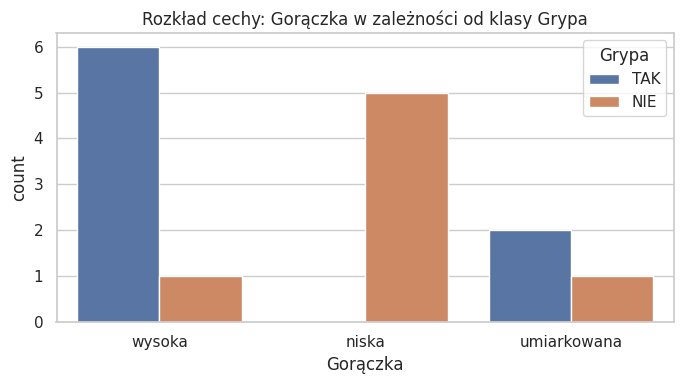

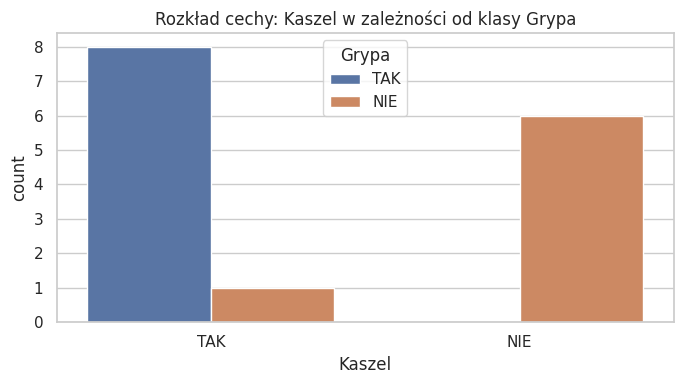

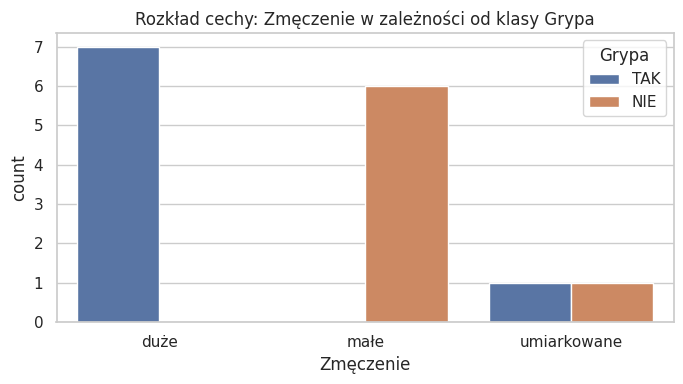

In [15]:
# 3) Wizualizacje rozkładów cech w klasach
sns.set_theme(style='whitegrid')

for col in features_g:
    plt.figure(figsize=(7,4))
    sns.countplot(data=df_grypa, x=col, hue='Grypa')
    plt.title(f"Rozkład cechy: {col} w zależności od klasy Grypa")
    plt.tight_layout()
    plt.show()

### 2b) Predykcja dla 3 pacjentów

Policzę \(P(Grypa=TAK\mid objawy)\) i \(P(Grypa=NIE\mid objawy)\) metodą Naive Bayes.  
Żeby nie wpaść w zera (bo dane są małe), używam wygładzania Laplace’a `alpha=1`.


In [16]:
patients = {
    'Pacjent A': {'Gorączka': 'wysoka', 'Kaszel': 'TAK', 'Zmęczenie': 'duże'},
    'Pacjent B': {'Gorączka': 'niska', 'Kaszel': 'NIE', 'Zmęczenie': 'małe'},
    'Pacjent C': {'Gorączka': 'umiarkowana', 'Kaszel': 'TAK', 'Zmęczenie': 'umiarkowane'},
}

classes_g, priors_g, cond_g, _ = fit_nb_categorical(df_grypa, target='Grypa', alpha=1.0)

rows = []
for name, sample in patients.items():
    scores, post = predict_proba(sample, classes_g, priors_g, cond_g)
    rows.append({
        'Pacjent': name,
        'score(TAK)': scores.get('TAK', np.nan),
        'score(NIE)': scores.get('NIE', np.nan),
        'P(TAK|objawy)': post.get('TAK', np.nan),
        'P(NIE|objawy)': post.get('NIE', np.nan),
        'Predykcja': 'TAK' if post.get('TAK',0) > post.get('NIE',0) else 'NIE'
    })

pd.DataFrame(rows).set_index('Pacjent')

,score(TAK),score(NIE),P(TAK|objawy),P(NIE|objawy),Predykcja
Pacjent,,,,,
Pacjent A,0.222149,0.002074,0.990750,0.009250,TAK
Pacjent B,0.000441,0.152444,0.002883,0.997117,NIE
Pacjent C,0.023802,0.004148,0.851586,0.148414,TAK


**Wnioski:**

- Pacjent A ma bardzo wysokie prawdopodobieństwo grypy (wysoka gorączka, kaszel, duże zmęczenie).
- Pacjent B ma bardzo niskie prawdopodobieństwo grypy (niska gorączka, brak kaszlu, małe zmęczenie).
- Pacjent C jest pośrodku, ale u niego kaszel podbija szansę grypy.
